# Ancestry: OCR for Newspaper with Amazon Textract
![pipeline](notebook_image/aws_resouces.png)
This notebook shows an end to end pipeline to extract the text from scanned newspaper.

In the first step, we crop an original newspaper into smaller images with bboxs (bounding boxes) generate from FCN model and postprocessing module.

Then, we feed our cropped images into Amazon Textract in read-order.

Finally, we extract text from images and evaluate the performance with our evaluation module.

The code structure is as following:

```
ancestry-demo
├── src/
│     ├── bbox_post_processing.py 
│     ├── constant.py : holds hard-coded variables
│     ├── data_loading.py : communicate with S3 for textract
│     ├── fcn.py : mask generation
│     ├── feature_extractor.py : support module for FCN
│     ├── text_analysis : metrics + functions to analyze the text ground truth
│     ├──
│     ├── file_util.py : supporting textract and some other results writing
│     ├── graph.py : supporting data structures for wenzhen bboxes processing
│     ├── image_processing.py : support textract pipeline
│     ├── mask2bbox.py 
│     ├── net.py : supporting fcn
│     ├── script.py (demo)
│     ├── text_analysis.py : support metrics evaluation + align gt / textract / abbyy
│     ├── metric_evaluation.py 
│     ├── textract.py : support the pipeline high-level textract pipeline
│     └── ReadMe.md
├── model/ 
│     └── best_1.5.pth.tar
├── demo_image/ 
│     ├── resized_015495008.png
│     ├── 015495008.png
│     └── ...
├── metrics/ 
│     ├── gt_label/
│     └── abbyy_post_process_lower/'
├── viualization/
│     ├── visual.wl/
│     └── visual_demo.nb
├── output/ 
│     ├── pred_mask
│     ├── bbox_raw
│     ├── bbox
│     ├── cropped_image
│     ├── ocr_plain_text
│     └── ocr_coords
└── Code-Walk-Through-MLSL.ipynb
```

In [1]:
import os
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import boto3
import src.net as net

# 1. Upload data to S3

This section is to simulate a user upload images to S3. The upload will trigger the pipeline to run. This upload should happen outside the compute resources. But for demonstration, we use the same instance to upload. We can also use AWS CLI to upload images to S3, run: `aws s3 cp <source> <target> [--options]`.

### Code

In [2]:
def upload_data_to_s3(path, bucket, prefix):
    print('Uploading data...')
    for file in [os.path.join(path, f) for f in os.listdir(path)]:
        target_file = prefix + '/' + file.split('/')[-1]
        boto3.Session().resource('s3').Bucket(bucket).upload_file(file, target_file)
    print('Done: {} files uploaded to {}'.format(len(os.listdir(path)), bucket+'/'+prefix))

### Demo

In [3]:
# original data location in local instance, take one image as an example
raw_data_dir = '../tianyu/FCN_Newspaper/data/gt_data/Images_PNG/1700-1899/'
# S3 target bucket path and file prefix
bucket = 'ancestry-demo'
prefix = 'raw-image-data'
# upload data into target bucket on Amazon S3
upload_data_to_s3(raw_data_dir, bucket, prefix)

Uploading data...
Done: 100 files uploaded to ancestry-demo/raw-image-data


## 2. Produce segmentation mask from image

We have trained a FCN model to segment images based on newspaper format/layout. The trained model have already saved in local instnace. Before doing inference, the image data preprocessing is required. In detail, we should download the data from S3 bucket, resize it into `512x512x3` and convert image into PyTorch tensor. We can inference with different models by spcifying the model path.


On the local instance, the file structure after first two steps should be this:

`project`

    end-to-end-notebook
    demo_image/
        015495008.png
        resized_015495008.png
        ...
    output/
        pred_mask/
            015495008.csv
        ...

### Demo of using FCN to create the mask

In [5]:
# a file on the S3
s3_file = 'ancestry-demo/raw-image-data/015495008.png'
# raw data downloaded from the S3
input_dir = 'demo_image/'
output_dir = 'output/pred_mask/'
# specify the model using for inference
#model_file = '../tianyu/FCN_Newspaper/experiment/fcn_newspaper_all_class/best_2.pth.tar'
model_file = 'model/best_1.5.pth.tar'
output_file_name, output = get_fcn_mask(s3_file, input_dir, model_file, output_dir)

Done: the file demo_image/015495008.png is downloaded


#### Visualization of FCN output

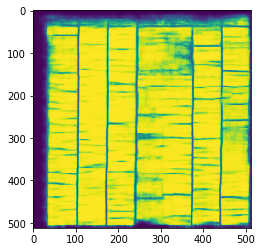

In [6]:
import matplotlib.pyplot as plt
plt.imshow(output.reshape(512,512))

## 3. Convert Mask to Bounding Box
The output of the FCN model is a mask. However, for newspaper, we need rigid bounding boxes to crop the segments. In detail, steps of the algorithm are:
- binarize masks based on a threshold value obtained experimentally
- apply morphological operations on the binarized image 
- apply flood fill algorithm to build connected components.
- get the bounding boxes for each connected component by finding the minimum and maximum x and y coordinates 

#### Create intermediate directory to save the intermediate results

In [7]:
from src import util

In [8]:
(input_dir, mask_dir, bbox_raw_dir, bbox_dir, cropped_img_dir, ocr_plain_dir, ocr_coord_dir) = util.create_experiment_directory('/home/ec2-user/SageMaker/ancestry-demo')
print(mask_dir)

/home/ec2-user/SageMaker/ancestry-demo/output/pred_mask


#### mask to bbox conversion

In [9]:
img_fname = '/home/ec2-user/SageMaker/ancestry-demo/demo_image/015495008.png'
key = img_fname.split('/')[-1].split('.')[0]
key

'015495008'

In [10]:
image = Image.open(img_fname)
w, h = image.size

In [11]:
mask_fname = mask_dir + '/' + key + '.csv'
mask_fname

'/home/ec2-user/SageMaker/ancestry-demo/output/pred_mask/015495008.csv'

In [12]:
from src.mask2bbox import mask_2_bboxes
raw_bbox_file_name = mask_2_bboxes(mask_fname, w, h)

In [13]:
raw_bbox_file_name

'/home/ec2-user/SageMaker/ancestry-demo/output/bbox_raw/015495008.csv'

## 4. Post-process Bounding Box
The raw bounding boxes from step 3 are not ideal. They contain small segments, and sometimes they overlap. To remove these defects , we applied several post-processing steps. 
- To remove overlapping bounding boxes, we applied simple intersection over union (IoU) thresholding. 
- To remove gaps between bounding boxes and better align the boundaries, we tried to cluster the raw bounding boxes in groups based on the euclidean distances of the centroid of each bounding box and then only kept the corner vertices of the cluster. This way, all the smaller bounding boxes whose centroids were close, were combined together with only one aligned boundary.     
- We incorporated further steps to merge bounding boxes. For example, we check if bounding boxes are vertically aligned in a same column segment, if so, we merge the neighboring vertically aligned bounding boxes. 

### Code

In [14]:
from src.bbox_post_processing_original import post_process_bboxes
from src.bbox_post import remove_overlapping_bboxes, clustering_bboxes, vertical_merge

def _get_raw_bboxes(raw_bbox_fname):
    df = pd.read_csv(raw_bbox_fname, header=None)
    pred_bboxes = df.to_numpy()
    return pred_bboxes

def post_processing_module(image, raw_bbox_fname):
    """
    :param image: numpy (image data
    :param raw_bbox_fname: str
    :return: a list of bbox
    """
    raw_bboxes = _get_raw_bboxes(raw_bbox_fname)
    less_bboxes = remove_overlapping_bboxes(raw_bboxes, r=0.8)
    ## Raj and Tianyu's result
    post_bboxes = post_process_bboxes(image, np.array(less_bboxes))
    ## Further improvement
    clustered_bboxes = clustering_bboxes(post_bboxes, r=70)
    ## Merge vertical
    if len(clustered_bboxes) > 16:
        try:
            bboxes, _, _ = vertical_merge(clustered_bboxes)
            return bboxes
        except:
            print("vertical merge failed")
    else:
        bboxes = clustered_bboxes
        return bboxes

### Demo

In [15]:
import pandas as pd
image = Image.open(img_fname)
w, h = image.size
image_data = np.asarray(image)
bboxes = post_processing_module(image_data, raw_bbox_file_name)
bboxes # list of bounding boxes with coordinates

array([[ 361,  575, 1092,  813],
       [ 361,  883, 1092, 2046],
       [ 361, 2116, 1092, 5690],
       [ 361, 5760, 1092, 7091],
       [1092,  575, 1787, 7077],
       [1787,  575, 2508, 2410],
       [1787, 2480, 2508, 7063],
       [2508,  575, 3858, 1962],
       [2508, 2088, 3858, 6054],
       [2508, 6124, 3858, 7063],
       [3858,  575, 4224, 1149],
       [3858, 1219, 4224, 2887],
       [3858, 2985, 4224, 5073],
       [3858, 5143, 4224, 6979],
       [4564,  575, 5234, 6138],
       [4564, 6208, 5234, 7063]])

## 5. Crop segmentations and send to Textract API
At the last step, we cropped the images with the segments' bounding boxes, and send each segment to Textract API to extract texts

### Code

In [16]:
from src.image_processing import image_trim, save_img
from src.textract import textract_text_only, translate_word_bboxes, textract_bbox_text, save_texts, flatten

In [17]:
from src.data_loading import upload_to_s3
from src.file_util import write_file
from src.constant import S3_BUCKET_NAME

def _get_key(img_name):
    return img_name.split('/')[-1].split('.')[0]

def textract_pipeline(image_path, image_data, bboxes, texts_path, opt, w=None, h=None):
    img_key = _get_key(img_name=image_path)
    textract_bboxs = []
    ocr_lines = []
    words_list = []
    root_path = '/'.join(image_path.split('/')[:-2])

    if opt == 1:
        for i, bbox in enumerate(bboxes):
            x, y, _, _ = bbox
            prefix, postfix = img_key, str(i).zfill(3)
            sub_image = image_trim(image_data, bbox)
            crop_img_path = root_path + '/output/cropped_image/{}_{}.jpg'.format(prefix, postfix)
            save_img(sub_image, crop_img_path)
            upload_to_s3(crop_img_path, S3_BUCKET_NAME, crop_img_path)
            lines = textract_text_only(bucket=S3_BUCKET_NAME, document=crop_img_path)
            ocr_lines.append(lines)
        print(ocr_lines)
        write_file(result_file=texts_path, lines=ocr_lines)
        print(texts_path)

    else:
        for i, bbox in enumerate(bboxes):
            x, y, _, _ = bbox
            prefix, postfix = img_key, str(i).zfill(3)
            sub_image = image_trim(image_data, bbox)
            crop_img_path = root_path + 'cropped_image/{}_{}.jpg'.format(prefix, postfix)
            save_img(sub_image, crop_img_path)
            upload_to_s3(crop_img_path, S3_BUCKET_NAME, crop_img_path)
            word_bboxes, words = textract_bbox_text(bucket=S3_BUCKET_NAME,
                                                             document=crop_img_path,
                                                             w=w,
                                                             h=h)
            wb = word_bboxes.astype(int).tolist()
            translated = translate_word_bboxes(wb, x, y)
            textract_bboxs.append(translated)
            words_list += words

        boxes = flatten(textract_bboxs)
        lines = []

        for i in range(len(boxes)):
            [x1, y1, x2, y2] = boxes[i]
            word = words_list[i]
            line = '{}, {}, {}, {}, {}'.format(word, x1, y1, x2, y2)
            lines.append(line)

        save_texts(lines, texts_path)
        print(texts_path)

### DEMO

In [18]:
from PIL import Image
import numpy as np
import pandas as pd

In [19]:
opt=1 # return plain text
ocr_res_path = ocr_plain_dir + '/' + key + '.txt'

In [20]:
textract_pipeline(img_fname, image_data, bboxes, ocr_res_path, opt, w, h)


[['Blairsrille Press', 'P.A.', 'SEPTEMBER 3; 1S69.', 'FRIDAY'], ['STATE TICKET.', 'coveaxot,', 'JOIIN W. GEARY.', 'SUTREME JUPGF,', 'IIENRY W. WILLLAMS.', 'COUNTY TICKET.', 'ASSEMBLY,', 'DAVID M. MARSHALL,', 'A. M. FULTON,', 'JACOB F. KREPS.', 'PROTHONOTARY.', 'JOHN LOWRY.', 'SUFRIER,', 'HENDERSON C. HOWARD.', 'TRFA9URER,', 'NOAH LOAR.', 'JOHN S. FLEMING.', 'ACDITOR,', 'A. z. HAMILTON.'], ['wa - /w', 'At the meeting of the Republican', 'county committee the Repuplican pa-', 'pers of the county were requested to', "'publish the following Digest of the", 'Registry Law, which we cheerfully do,', 'although the PRESS was the only Re-', 'pablican paper in this county which', 'had enterprise enough to publish the', 'Law entire. which was done several', 'weeks ago. We again advise all to fa-', 'miliarize themselves with its provi-', 'FIRST:-DUTINS OF ASSTISSORS.', 'By Section 8, of the Registration act,', 'each Assessor is required to take up', 'the transcript or list of taxables resi-', 'dent